In [5]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
import numpy as np
import pandas as pd
import random
import sys
import io
import re

In [7]:
songs = pd.read_csv('drake-songs.csv')

In [8]:
text = ''

for index, row in songs['lyrics'].iteritems():
    cleaned = str(row).lower().replace(' ', '\n')
    text = text + " ".join(re.findall(r"[a-z']+", cleaned))
    
len(text)

367372

In [9]:
import re

tokens = re.findall(r"[a-z'\s]", text)

chars = sorted(list(set(tokens)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 28


In [10]:
chars

[' ',
 "'",
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [11]:

maxlen = 40
step = 3
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
    
print('nb sequences:', len(sentences))

nb sequences: 122444


In [12]:


x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [13]:

print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01))

Build model...


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               80384     
_________________________________________________________________
dense_1 (Dense)              (None, 28)                3612      
_________________________________________________________________
activation_1 (Activation)    (None, 28)                0         
Total params: 83,996
Trainable params: 83,996
Non-trainable params: 0
_________________________________________________________________


In [15]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [16]:
def on_epoch_end(epoch, logs):
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [17]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

history = model.fit(
    x, 
    y,
    batch_size=128,
    epochs=10,
    callbacks=[print_callback]
)

Epoch 1/10
122444/122444 [==============================] - 47s 383us/step - loss: 1.8612
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "it means all i see is fireworks all i se"
it means all i see is fireworks all i see i started it i wanna the money the chise i still i stoped to my how i'm the prince to my fickin' a started i don't the beat it i stope it i see i don't the money the beat the money i see i'm so my like the mine the more and the money the the but i don't the more for my fack it i see i'm the money i don't the mome it i see the more it i don't the money the cheate it the more the more i wanna the 
----- diversity: 0.5
----- Generating with seed: "it means all i see is fireworks all i se"
it means all i see is fireworks all i sear the prory on the my kees this i wishin' you down with my lite i been a nigga told my niggas i could i told is a but the back and i stike the me around that i see to my let tell my pars it i see my best it 

urn i really used to feel like they love it i take it they live like my that you the fuckin' and i see me on my i'm a mind's something i wanna see thing and i'mma on the way the stoo lackin' on the shopling all the a smoke i don't know what it that shit that's on over the could be the world time i back the jumpmay in the would say how you know you the would be so is and here staring that i wanna do of the that i could be the face with t
Epoch 8/10
122444/122444 [==============================] - 45s 371us/step - loss: 1.2516
----- Generating text after Epoch: 7
----- diversity: 0.2
----- Generating with seed: " over crumbs where the bread at how they"
 over crumbs where the bread at how they got it all the shot the bight and i'm the show the came i don't be the same i got me give you do you should take the shot the money the fince the shunin' and i don't say you don't trying to be the show i'm the same i don't need the came i got a shots to back the money the same i don't trying to be 

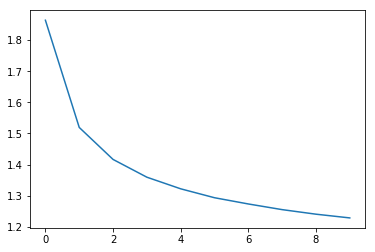

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['loss'])

In [15]:
def generate_output():
    generated = ''
    usr_input = input("Write the beginning of your poem, the Drake machine will complete it. Your input is: ")

    sentence = ('{0:0>' + str(Tx) + '}').format(usr_input).lower()
    generated += usr_input 

    sys.stdout.write("\n\nHere is your poem: \n\n") 
    sys.stdout.write(usr_input)
    for i in range(400):

        x_pred = np.zeros((1, Tx, len(chars)))

        for t, char in enumerate(sentence):
            if char != '0':
                x_pred[0, t, char_indices[char]] = 1.

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature = 0.2)
        next_char = indices_char[next_index]

        generated += next_char
        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()

        if next_char == '\n':
            continue

In [16]:
Tx = 40
generate_output()

Write the beginning of your poem, the Drake machine will complete it. Your input is: hello my name is mayur


Here is your poem: 

hello my name is mayurin' the way in the same i don't know they gon' think i don't know they know you know you know you know you know you know you know you know you know you know you know you know you know you know you know you know you know you know you know you got the bandwaybod and she said i want the shit i don't know you say it i got me and i got the man on the bottom now we're to the club i don't know they know 

In [20]:
import utils

In [ ]:
utils.save_model_weights(model)